In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torchvision.models as models

from torchinfo import summary

> Attention : utilisation d'un répertoire de données en dehors de l'environnement do notebook !

torch.Size([3, 345, 500]) 255


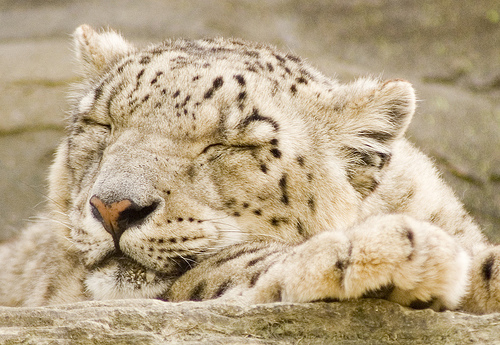

In [2]:
#DataPath = "/Users/me/Documents/Work/Dev/_data/imagene_val_images"
DataPath = "/Users/me/Documents/Work/Dev/_data/imagenet-sample-images-master"
ImageFile = "n02128757_snow_leopard.JPEG" #"ILSVRC2012_val_00038102_n01756291.JPEG" #"ILSVRC2012_val_00001971_n02105855.JPEG"
filename = os.path.join(DataPath, ImageFile)
img1_t = read_image(filename)
print(img1_t.size(), img1_t.max().item())
img1 = T.functional.to_pil_image(img1_t)
img1

In [61]:
def rgb_distributions(image_array):
    R = image_array[:, :, 0]
    G = image_array[:, :, 1]
    B = image_array[:, :, 2]

    # Créer des histogrammes pour chaque canal
    bin_edges = np.linspace(0, 255, 256)
    hist_R, _ = np.histogram(R, bins=bin_edges, density=True)
    hist_G, _ = np.histogram(G, bins=bin_edges, density=True)
    hist_B, _ = np.histogram(B, bins=bin_edges, density=True)

    # Créer une figure pour les courbes
    plt.figure(figsize=(10, 6))

    # Afficher les courbes
    plt.step(bin_edges[:-1], hist_R, where='mid', color='red', label='Rouge')
    plt.step(bin_edges[:-1], hist_G, where='mid', color='green', label='Vert')
    plt.step(bin_edges[:-1], hist_B, where='mid', color='blue', label='Bleu')

    # Ajouter des légendes et des titres
    plt.title('Distribution des canaux RGB')
    plt.xlabel('Intensité')
    plt.ylabel('Densité')
    plt.legend()

    # Afficher le graphique
    plt.show()

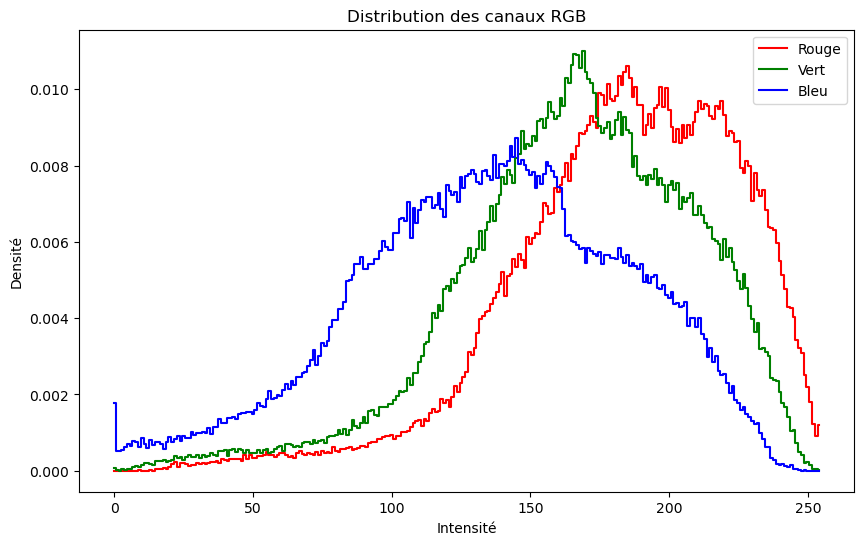

In [65]:
rgb_distributions(img1_t.numpy().transpose(1, 2, 0))

torch.Size([3, 224, 224]) 0.003921568859368563 1.0


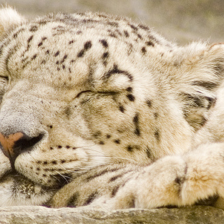

In [27]:
transforms0 = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda t: t/255.), # because read_image -> [0..255]
])

input0 = transforms0(img1_t)
print(input0.size(), input0.min().item(), input0.max().item())
T.functional.to_pil_image(input0)

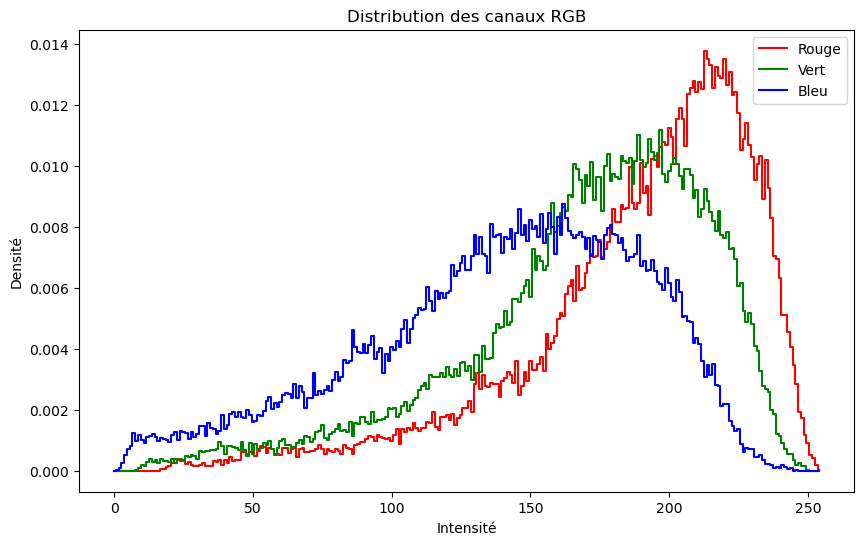

In [67]:
rgb_distributions(input0.numpy().transpose(1, 2, 0)*255)

In [58]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda t: t/255.), # because read_image -> [0..255]
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

torch.Size([3, 224, 224]) -1.895658254623413 2.483137607574463


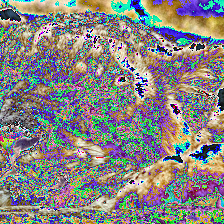

In [59]:
input = transforms(img1_t)
print(input.size(), input.min().item(), input.max().item())
T.functional.to_pil_image(input)

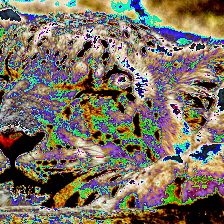

In [60]:
T.functional.to_pil_image(torch.nn.functional.relu(input))

In [16]:
class UnNormalize(T.Normalize):
    def __init__(self, mean: List[float], std: List[float], *args, **kwargs):
        new_mean = [-m/s for m, s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

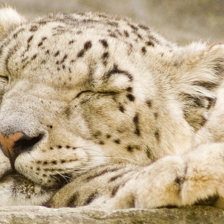

In [17]:
input_un = UnNormalize(imagenet_mean, imagenet_std)(input)
T.functional.to_pil_image(input_un)

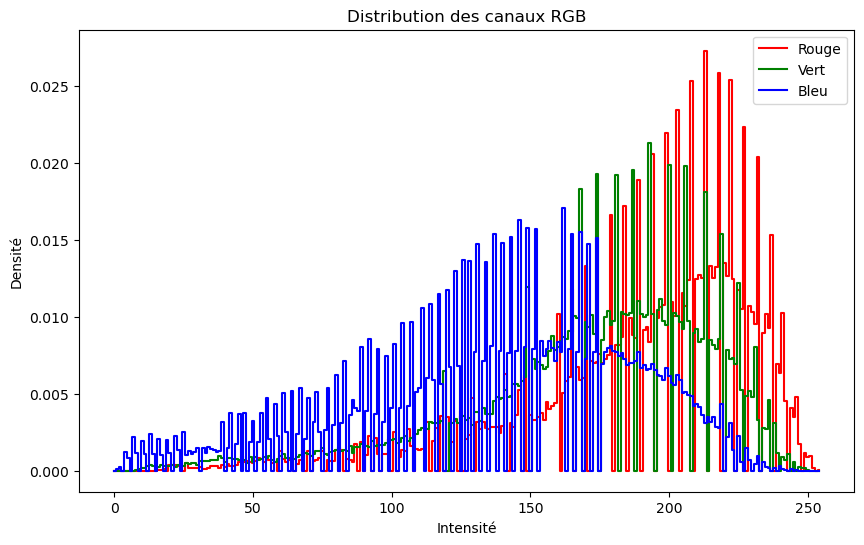

In [68]:
rgb_distributions(input_un.numpy().transpose(1, 2, 0)*255)

In [6]:
batch_input = input.unsqueeze(dim=0)
batch_input.size()

torch.Size([1, 3, 224, 224])

In [7]:
model = models.alexnet(weights='IMAGENET1K_V1')
model_features = model.features
summary(model_features, input_size=torch.Size([1, 3, 224, 224]))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 256, 6, 6]            --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─ReLU: 1-2                              [1, 64, 55, 55]           --
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 192, 27, 27]          307,392
├─ReLU: 1-5                              [1, 192, 27, 27]          --
├─MaxPool2d: 1-6                         [1, 192, 13, 13]          --
├─Conv2d: 1-7                            [1, 384, 13, 13]          663,936
├─ReLU: 1-8                              [1, 384, 13, 13]          --
├─Conv2d: 1-9                            [1, 256, 13, 13]          884,992
├─ReLU: 1-10                             [1, 256, 13, 13]          --
├─Conv2d: 1-11                           [1, 256, 13, 13]          590,080
├─ReLU: 1-12                             [1, 256, 13, 13]    

In [8]:
for layer in model_features:
    print(layer)

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


In [9]:
layer = model_features[0]
layer

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [39]:
output = batch_input
print(output.size())
for layer in model_features[:1]:
    output = layer(output)
    print(output.size(), layer)

torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 55, 55]) Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


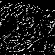

In [40]:
T.functional.to_pil_image(torch.nn.functional.relu(output.detach().squeeze()[0]))
#T.functional.to_pil_image(output.detach().squeeze()[0])

torch.Size([1, 3, 224, 224]) -71.30252075195312 49.60698318481445


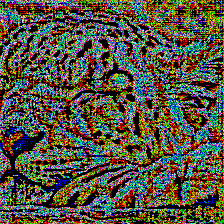

In [55]:
weights = model_features[0].weight
layer =  model_features[0]
b_output = torch.nn.functional.conv_transpose2d(
    output,
    weights,
    stride=layer.stride,
    padding=layer.padding,
    output_padding=1,
    dilation=layer.dilation
    )
print(b_output.size(), b_output.min().item(), b_output.max().item())
T.functional.to_pil_image(torch.nn.functional.relu(b_output.detach().squeeze()))


torch.Size([3, 224, 224]) 0.0 1.0


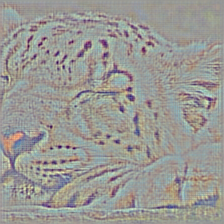

In [49]:
#b_output_un = UnNormalize(imagenet_mean, imagenet_std)(b_output.detach().squeeze())
b_output_un = b_output.detach().squeeze()
b_output_un = b_output_un - b_output_un.min()
b_output_un = b_output_un / b_output_un.max()
print(b_output_un.size(), b_output_un.min().item(), b_output_un.max().item())
T.functional.to_pil_image(torch.nn.functional.relu(b_output_un))

(224, 224, 3) 0 255


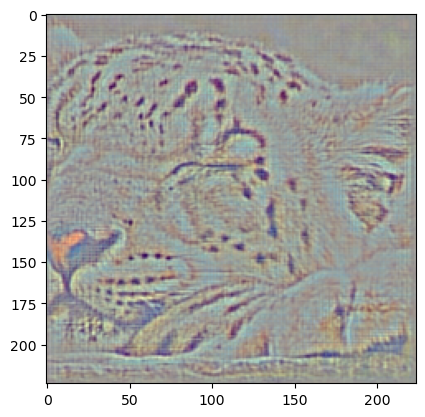

In [57]:
b_output_un_np = b_output.detach().squeeze().numpy().transpose(1, 2, 0)
b_output_un_np = (b_output_un_np - b_output_un_np.min()) / (b_output_un_np.max() - b_output_un_np.min()) * 255
b_output_un_np = b_output_un_np.astype(np.uint8)
print(b_output_un_np.shape, b_output_un_np.min(), b_output_un_np.max())
plt.imshow(b_output_un_np)